In [97]:
import utils
utils.assign_free_gpus()
from utils import read_im, save_im, normalize # For showing the solutions
import pathlib  # For showing the solutions
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

No GPU available, using CPU


### Dataset

In [98]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5) # Normalize data
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [99]:
def create_model(hidden=False):
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    if hidden:    
        model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(28*28*1, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    else:
        model = nn.Sequential(
            nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
            nn.Linear(28*28*1, 10)
                
            # No need to include softmax, as this is already combined in the loss function
        )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [100]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [101]:
# Hyperparameters
learning_rate = .0192
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [102]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:32<00:00, 28.70it/s]


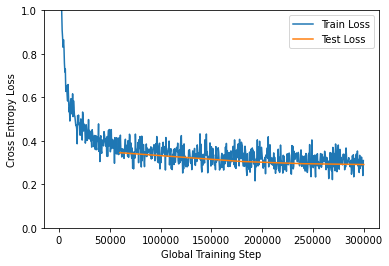

Final Test loss: 0.2910342051285752. Final Test accuracy: 0.9166


In [103]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task A

In [104]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)


image_transform_bad = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(0.5, 0.5) # Normalize data
])

dataloader_train_bad, dataloader_test_bad = dataloaders.load_dataset(batch_size, image_transform_bad)
model_bad = create_model()

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model_bad.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model_bad,
  dataloader_train=dataloader_train_bad,
  dataloader_test=dataloader_test_bad,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_bad, test_loss_dict_bad = trainer.train(num_epochs)

Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4: 100%|██████████| 938/938 [00:19<00:00, 47.15it/s]


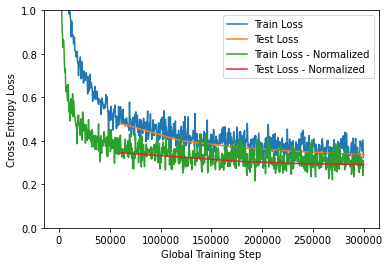

Final Test loss: 2.3653223000134633. Final Test accuracy: 0.6446


In [105]:
# We can now plot the two models against eachother

# Plot loss
utils.plot_loss(train_loss_dict_bad, label="Train Loss")
utils.plot_loss(test_loss_dict_bad, label="Test Loss")
utils.plot_loss(train_loss_dict, label="Train Loss - Normalized")
utils.plot_loss(test_loss_dict, label="Test Loss - Normalized")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4aBoth.png")
plt.savefig("image_solutions/task_4aBoth.pdf")

plt.show()

torch.save(model_bad.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model_bad, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task B

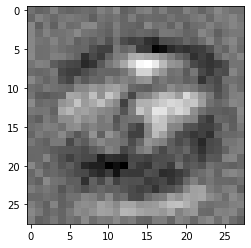

In [106]:
if True:
    weight = list(model.children())[1].weight.cpu().data

    for w in range(weight.shape[0]):
        im = np.array(weight[w]).reshape((28, 28))

        plt.imsave("image_solutions/weights/" + "weightt_" + str(w) + ".pdf" , im, cmap="gray")
        plt.imshow(im, cmap="gray")

### Task C

In [107]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

model_lr1 = create_model()

learning_rate = 1.0000
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model_lr1.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model_lr1,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_lr1, test_loss_dict_lr1 = trainer.train(num_epochs)
num_epochs = 5

Training epoch 4: 100%|██████████| 938/938 [00:26<00:00, 35.85it/s]


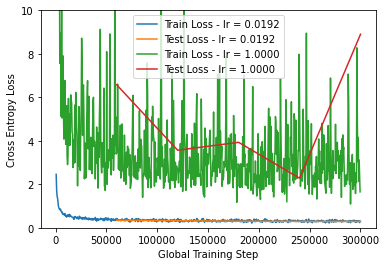

Final Test loss: 8.901959961387002. Final Test accuracy: 0.7172


In [108]:
# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss - lr = 0.0192")
utils.plot_loss(test_loss_dict, label="Test Loss - lr = 0.0192")
utils.plot_loss(train_loss_dict_lr1, label="Train Loss - lr = 1.0000")
utils.plot_loss(test_loss_dict_lr1, label="Test Loss - lr = 1.0000")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 10])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4cBoth.png")
plt.savefig("image_solutions/task_4cBoth.pdf")

plt.show()

torch.save(model_lr1.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model_lr1, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task D

In [109]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

model_hl = create_model(True)

learning_rate = 0.0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model_hl.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model_hl,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_hl, test_loss_dict_hl = trainer.train(num_epochs)
num_epochs = 5

Training epoch 4: 100%|██████████| 938/938 [00:18<00:00, 49.77it/s]


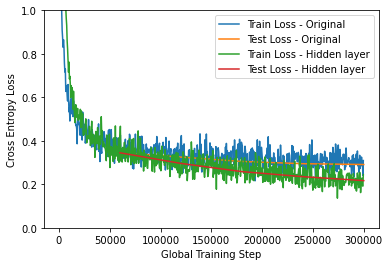

Final Test loss: 0.2170101859944926. Final Test accuracy: 0.9369


In [110]:
# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss - Original")
utils.plot_loss(test_loss_dict, label="Test Loss - Original")
utils.plot_loss(train_loss_dict_hl, label="Train Loss - Hidden layer")
utils.plot_loss(test_loss_dict_hl, label="Test Loss - Hidden layer")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4dBoth.png")
plt.savefig("image_solutions/task_4dBoth.pdf")

plt.show()

torch.save(model_lr1.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model_hl, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")